# TFM. Modelo predictivo llamadas Call Center
## MVP

## Importacion de librerias 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import datetime
import calendar

pd.options.display.max_columns = None

### Importacion de los datos de envios por oficinas

In [2]:
df_shippings = pd.read_csv('data/shippings.csv', low_memory=False)

In [3]:
df_shippings['Franquicia destino'].unique()

array([4800, 4802, 4803, 4806, 4810], dtype=int64)

##### Filtramos oficinas

In [4]:
#df = df_shippings[ (df_shippings['Franquicia destino']==4800) ]

In [5]:
df = df_shippings
df.columns

Index(['Unnamed: 0', 'Fecha envío', 'Número envío', 'Id. Fiscal',
       'Nombre Comercial', 'Código servicio', 'Nombre Rem', 'Población Rem',
       'CP Rem', 'Nombre vía Rem', 'Nombre', 'Población', 'Código postal',
       'Nombre vía', 'Total bultos', 'Franquicia origen', 'Franquicia destino',
       'Total', 'Estado', 'Tipo anomalía', 'Motivo', 'Importe Total'],
      dtype='object')

In [6]:
df = df.iloc[:, [1,5,16]]
df.head()

,Fecha envío,Código servicio,Franquicia destino
0,01/01/2019,Económico,4800
1,01/01/2019,Marítimo baleares,4800
2,01/01/2019,E-commerce,4800
3,01/01/2019,E-commerce,4800
4,01/01/2019,E-commerce,4800


In [7]:
df['Fecha envío'] = pd.to_datetime(df['Fecha envío'])

<ipython-input-7-90ac39e29746>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha envío'] = pd.to_datetime(df['Fecha envío'])


#### Filtramos fechas en el dataset

In [8]:
#df = df[df['Fecha envío'] > '01-6-2020']
#df.head()

In [9]:
def updateDate(s):
    envio24h = ['Urgente 8:30', 'Urgente 10','Urgente 12','Urgente 14','Urgente 19', \
               'Urgente 8:30 expedición', 'Urgente 10 expedición','Urgente 12 expedición', \
               'Urgente 14 expedición','Urgente 19 expedición','Urgente hoy','Burofax', \
               'Documentos 14','Mascotas','Bag 14','Bag 19','Express documentos']
    envio48h = ['Económico','E-commerce','Mrw economy (ecopaq)','Retorno canje']
    maritimo = ['Marítimo baleares']
    
    nDate = np.nan
    ## Arreglar los 24H
    if s['Código servicio'] in envio24h:
        nDate = s['Fecha envío'] + datetime.timedelta(days=0)
    elif s['Código servicio'] in envio48h:
        nDate = s['Fecha envío'] + datetime.timedelta(days=0)
    else:
        nDate = s['Fecha envío'] + datetime.timedelta(days=0)
    
    if nDate.isoweekday() == 7:
        nDate = nDate + datetime.timedelta(days=0)
    elif nDate.isoweekday() == 6:
        nDate = nDate + datetime.timedelta(days=0)
        
    return nDate

In [10]:
df['xDate'] = df.apply(updateDate, axis=1)

<ipython-input-10-99700ddc10e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['xDate'] = df.apply(updateDate, axis=1)


In [11]:
df[df['xDate'].isnull()]

,Fecha envío,Código servicio,Franquicia destino,xDate


In [12]:
df['Fecha envío'] =  pd.to_datetime(df['xDate'])

<ipython-input-12-9e72888f5bd0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha envío'] =  pd.to_datetime(df['xDate'])


In [13]:
dias = list(calendar.day_name)

In [14]:
df['dayofweek'] = [dias[numero] for numero in df['Fecha envío'].dt.dayofweek]
df.head()

<ipython-input-14-0dfaeb8ecb17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = [dias[numero] for numero in df['Fecha envío'].dt.dayofweek]


,Fecha envío,Código servicio,Franquicia destino,xDate,dayofweek
0,2019-01-01,Económico,4800,2019-01-01,Tuesday
1,2019-01-01,Marítimo baleares,4800,2019-01-01,Tuesday
2,2019-01-01,E-commerce,4800,2019-01-01,Tuesday
3,2019-01-01,E-commerce,4800,2019-01-01,Tuesday
4,2019-01-01,E-commerce,4800,2019-01-01,Tuesday


In [15]:
df['Fecha envío'] =  pd.to_datetime(df['Fecha envío']).astype('str')

<ipython-input-15-bee2ca5c2dd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha envío'] =  pd.to_datetime(df['Fecha envío']).astype('str')


In [16]:
df['Código servicio'].unique()

array(['Económico', 'Marítimo baleares', 'E-commerce', 'Urgente 12',
       'Urgente 10', 'Mascotas', 'Urgente 14', 'Urgente 8:30',
       'Urgente 12 expedición', 'Burofax', 'Urgente 19 expedición',
       'Urgente hoy', nan, 'Documentos 14', 'Urgente 8:30 expedición',
       'Urgente 10 expedición', 'Urgente 19', 'Mrw economy (ecopaq)',
       'Bag 19', 'Retorno albarán', 'E-commerce canje',
       'Express documentos', 'Bag 14', 'Retorno canje',
       'Urgente 14 expedición', 'Devolución burofax',
       'OperativaServicioEnumECOBA', 'OperativaServicioEnumU19E;U19;E',
       'Urgente funchal', 'Express paquetes', 'E-Commerce', 'Plan ayuda',
       'Ecobox 25', 'Retorno burofax'], dtype=object)

In [18]:
train = df[['Fecha envío','Código servicio','dayofweek']]
train.reset_index(inplace=True)
train = train[['Fecha envío','Código servicio','dayofweek']]
train['total'] = 1

In [19]:
train.head()

,Fecha envío,Código servicio,dayofweek,total
0,2019-01-01,Económico,Tuesday,1
1,2019-01-01,Marítimo baleares,Tuesday,1
2,2019-01-01,E-commerce,Tuesday,1
3,2019-01-01,E-commerce,Tuesday,1
4,2019-01-01,E-commerce,Tuesday,1


In [22]:
encoder = OneHotEncoder(handle_unknown='ignore')
enc = train[['Código servicio']]

In [23]:
encoder.fit(enc.values.reshape(-1,1))
encoder.categories_

[array(['Bag 14', 'Bag 19', 'Burofax', 'Devolución burofax',
        'Documentos 14', 'E-Commerce', 'E-commerce', 'E-commerce canje',
        'Ecobox 25', 'Económico', 'Express documentos', 'Express paquetes',
        'Marítimo baleares', 'Mascotas', 'Mrw economy (ecopaq)',
        'OperativaServicioEnumECOBA', 'OperativaServicioEnumU19E;U19;E',
        'Plan ayuda', 'Retorno albarán', 'Retorno burofax',
        'Retorno canje', 'Urgente 10', 'Urgente 10 expedición',
        'Urgente 12', 'Urgente 12 expedición', 'Urgente 14',
        'Urgente 14 expedición', 'Urgente 19', 'Urgente 19 expedición',
        'Urgente 8:30', 'Urgente 8:30 expedición', 'Urgente funchal',
        'Urgente hoy', nan], dtype=object)]

In [24]:
encoded = encoder.transform(enc.values.reshape(-1,1))
encoded_df = pd.DataFrame(encoded.todense())
encoded_df.columns = encoder.categories_[0]

In [25]:
train = pd.concat([train,encoded_df], axis=1)

In [26]:
#encoder = OneHotEncoder(handle_unknown='ignore')
enc = train[['dayofweek']]
encoder.fit(enc.values.reshape(-1,1))
encoded = encoder.transform(enc.values.reshape(-1,1))
encoded_df = pd.DataFrame(encoded.todense())
encoded_df.columns = encoder.categories_[0]

In [27]:
train = pd.concat([train,encoded_df], axis=1)

In [28]:
#encoder = OneHotEncoder(handle_unknown='ignore')
#enc = train[['Código postal']]
#encoder.fit(enc.values.reshape(-1,1))
#encoded = encoder.transform(enc.values.reshape(-1,1))
#encoded_df = pd.DataFrame(encoded.todense())
#encoded_df.columns = encoder.categories_[0]

In [29]:
#train = pd.concat([train,encoded_df], axis=1)

In [30]:
train.drop(columns=['Código servicio','dayofweek'], inplace=True)

In [31]:
train = train.groupby(['Fecha envío']).sum()

In [32]:
train.head()

,total,Bag 14,Bag 19,Burofax,Devolución burofax,Documentos 14,E-Commerce,E-commerce,E-commerce canje,Ecobox 25,Económico,Express documentos,Express paquetes,Marítimo baleares,Mascotas,Mrw economy (ecopaq),OperativaServicioEnumECOBA,OperativaServicioEnumU19E;U19;E,Plan ayuda,Retorno albarán,Retorno burofax,Retorno canje,Urgente 10,Urgente 10 expedición,Urgente 12,Urgente 12 expedición,Urgente 14,Urgente 14 expedición,Urgente 19,Urgente 19 expedición,Urgente 8:30,Urgente 8:30 expedición,Urgente funchal,Urgente hoy,NaN,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Fecha envío,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,33,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0
2019-01-02,1923,0.0,5.0,14.0,0.0,5.0,0.0,424.0,0.0,0.0,311.0,0.0,0.0,723.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,127.0,0.0,187.0,10.0,13.0,0.0,50.0,38.0,5.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1923.0
2019-01-03,1408,0.0,0.0,12.0,0.0,3.0,0.0,348.0,0.0,0.0,208.0,0.0,0.0,540.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,80.0,4.0,131.0,4.0,5.0,0.0,1.0,42.0,3.0,1.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,1408.0,0.0,0.0
2019-01-04,3220,0.0,1.0,10.0,0.0,3.0,0.0,888.0,1.0,0.0,442.0,0.0,0.0,1183.0,25.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,176.0,7.0,286.0,14.0,3.0,0.0,104.0,69.0,5.0,1.0,0.0,0.0,0.0,3220.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-05,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0


In [33]:
train.columns

Index([                          'total',                          'Bag 14',
                                'Bag 19',                         'Burofax',
                    'Devolución burofax',                   'Documentos 14',
                            'E-Commerce',                      'E-commerce',
                      'E-commerce canje',                       'Ecobox 25',
                             'Económico',              'Express documentos',
                      'Express paquetes',               'Marítimo baleares',
                              'Mascotas',            'Mrw economy (ecopaq)',
            'OperativaServicioEnumECOBA', 'OperativaServicioEnumU19E;U19;E',
                            'Plan ayuda',                 'Retorno albarán',
                       'Retorno burofax',                   'Retorno canje',
                            'Urgente 10',           'Urgente 10 expedición',
                            'Urgente 12',           'Urgente 12 expedición',

In [34]:
train.describe().iloc[0,0] ##Cantidad de registros

851.0

In [35]:
columnas = ['E-commerce','Económico','Marítimo baleares',\
            'Urgente 10','Urgente 12','Urgente 19','Urgente 19 expedición',\
            'Monday','Tuesday','Wednesday','Thursday','Friday']

In [36]:
#train = train[columnas]
#train.head()

In [37]:
#train = train.iloc[:,1:-7]

In [38]:
#train.head()

In [39]:

train.Monday = [ 1 if value > 0 else 0 for value in train.Monday]
train.Tuesday = [ 1 if value > 0 else 0 for value in train.Tuesday]
train.Wednesday = [ 1 if value > 0 else 0 for value in train.Wednesday]
train.Thursday = [ 1 if value > 0 else 0 for value in train.Thursday]
train.Friday = [ 1 if value > 0 else 0 for value in train.Friday]
train.Saturday = [ 1 if value > 0 else 0 for value in train.Saturday]
train.Sunday = [ 1 if value > 0 else 0 for value in train.Sunday]
train.head()


,total,Bag 14,Bag 19,Burofax,Devolución burofax,Documentos 14,E-Commerce,E-commerce,E-commerce canje,Ecobox 25,Económico,Express documentos,Express paquetes,Marítimo baleares,Mascotas,Mrw economy (ecopaq),OperativaServicioEnumECOBA,OperativaServicioEnumU19E;U19;E,Plan ayuda,Retorno albarán,Retorno burofax,Retorno canje,Urgente 10,Urgente 10 expedición,Urgente 12,Urgente 12 expedición,Urgente 14,Urgente 14 expedición,Urgente 19,Urgente 19 expedición,Urgente 8:30,Urgente 8:30 expedición,Urgente funchal,Urgente hoy,NaN,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Fecha envío,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,33,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0
2019-01-02,1923,0.0,5.0,14.0,0.0,5.0,0.0,424.0,0.0,0.0,311.0,0.0,0.0,723.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,127.0,0.0,187.0,10.0,13.0,0.0,50.0,38.0,5.0,0.0,0.0,0.0,7.0,0,0,0,0,0,0,1
2019-01-03,1408,0.0,0.0,12.0,0.0,3.0,0.0,348.0,0.0,0.0,208.0,0.0,0.0,540.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,80.0,4.0,131.0,4.0,5.0,0.0,1.0,42.0,3.0,1.0,0.0,0.0,23.0,0,0,0,0,1,0,0
2019-01-04,3220,0.0,1.0,10.0,0.0,3.0,0.0,888.0,1.0,0.0,442.0,0.0,0.0,1183.0,25.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,176.0,7.0,286.0,14.0,3.0,0.0,104.0,69.0,5.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0
2019-01-05,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0


In [40]:
train = train.drop(labels=['Saturday','Sunday'], axis=1)

In [41]:
train.to_pickle('./data/df_Envios')

<ipython-input-43-02b8cc7f053a>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


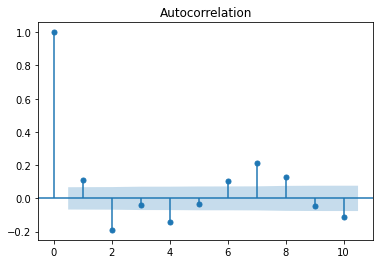

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(train['total'], lags=10, alpha=0.05)
fig.show()

In [44]:
train['total'].autocorr(lag=7), train['total'].autocorr(lag=14), train['total'].autocorr(lag=21)

(0.21367008437377788, 0.11611979553792952, 0.1825426651556608)